Link to lesson: https://carpentries-incubator.github.io/SDC-BIDS-fMRI/05-data-cleaning-with-nilearn/index.html

In [14]:
import os
from nilearn import image as img
from nilearn import plotting as plot
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
%matplotlib inline

In [5]:
func_dir = '../data/ds000030/derivatives/fmriprep/sub-10788/func'
func = os.path.join(func_dir, 'sub-10788_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
confound = os.path.join(func_dir, 'sub-10788_task-rest_bold_confounds.tsv')
mask = os.path.join(func_dir,'sub-10788_task-rest_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

In [6]:
#Delimiter is \t --> tsv is a tab-separated spreadsheet
confound_df = pd.read_csv(confound, delimiter='\t')
confound_df.head()

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,tCompCor03,...,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,-0.930193,0.920688,NaN,NaN,NaN,NaN,-0.046769,-0.049587,0.073918,-0.039073,...,0.038453,-0.069422,0.010756,-0.000146,0.024767,-0.072305,-0.002255,-0.001793,-0.001361,0.000352
1,-1.299883,-0.975339,0.989721,23.510405,0.927776,0.063529,0.026291,0.079843,-0.007816,0.098581,...,0.035330,0.036567,0.064617,-0.172934,0.025501,-0.076729,-0.005197,-0.002065,-0.000951,0.000778
2,-1.650409,-1.183255,0.961757,22.846130,0.910688,0.126806,-0.023824,-0.024723,0.037845,-0.069131,...,0.109473,-0.011433,0.132771,0.051937,0.020329,-0.016372,0.028021,-0.001914,-0.001361,0.000778
3,-1.774555,-0.651059,0.986363,23.430628,0.919731,0.216581,-0.009827,-0.050729,-0.036944,0.124505,...,0.037130,-0.012983,0.081047,-0.151147,0.017615,-0.066170,-0.046772,-0.000446,-0.001453,0.000552
4,-1.243550,-0.048672,1.055433,25.071358,0.977912,0.105998,-0.041097,0.049297,0.104557,-0.080688,...,-0.026669,-0.074854,0.055892,0.007484,0.027412,-0.106554,-0.024217,-0.000753,-0.001287,0.000359


# Setting up Confound variables for regression

In [7]:
confound_vars = ['X','Y','Z','RotX','RotY','RotZ','GlobalSignal','aCompCor01','aCompCor02']
confound_df = confound_df[confound_vars]
confound_df.head()

,X,Y,Z,RotX,RotY,RotZ,GlobalSignal,aCompCor01,aCompCor02
0,0.024767,-0.072305,-0.002255,-0.001793,-0.001361,0.000352,0.920688,-0.119012,0.038453
1,0.025501,-0.076729,-0.005197,-0.002065,-0.000951,0.000778,-0.975339,-0.032825,0.035330
2,0.020329,-0.016372,0.028021,-0.001914,-0.001361,0.000778,-1.183255,-0.014954,0.109473
3,0.017615,-0.066170,-0.046772,-0.000446,-0.001453,0.000552,-0.651059,-0.039344,0.037130
4,0.027412,-0.106554,-0.024217,-0.000753,-0.001287,0.000359,-0.048672,-0.101818,-0.026669


## Computing temporal derivatives for confound variables

In [8]:
for col in confound_df.columns:

    #Example X --> X_dt
    new_name = '{}_dt'.format(col)

    #Compute differences for each pair of rows from start to end.
    new_col = confound_df[col].diff()

    #Make new column in our dataframe
    confound_df[new_name] = new_col

confound_df.head()


,X,Y,Z,RotX,RotY,RotZ,GlobalSignal,aCompCor01,aCompCor02,X_dt,Y_dt,Z_dt,RotX_dt,RotY_dt,RotZ_dt,GlobalSignal_dt,aCompCor01_dt,aCompCor02_dt
0,0.024767,-0.072305,-0.002255,-0.001793,-0.001361,0.000352,0.920688,-0.119012,0.038453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.025501,-0.076729,-0.005197,-0.002065,-0.000951,0.000778,-0.975339,-0.032825,0.035330,0.000734,-0.004424,-0.002942,-0.000272,0.000410,0.000426,-1.896026,0.086187,-0.003123
2,0.020329,-0.016372,0.028021,-0.001914,-0.001361,0.000778,-1.183255,-0.014954,0.109473,-0.005172,0.060357,0.033218,0.000151,-0.000410,0.000000,-0.207916,0.017872,0.074143
3,0.017615,-0.066170,-0.046772,-0.000446,-0.001453,0.000552,-0.651059,-0.039344,0.037130,-0.002715,-0.049798,-0.074793,0.001467,-0.000092,-0.000226,0.532196,-0.024390,-0.072342
4,0.027412,-0.106554,-0.024217,-0.000753,-0.001287,0.000359,-0.048672,-0.101818,-0.026669,0.009798,-0.040384,0.022555,-0.000307,0.000166,-0.000192,0.602387,-0.062474,-0.063799


## Dropping Dummy TRs

In [9]:
raw_func_img = img.load_img(func)
raw_func_img.shape

(65, 77, 49, 152)

In [10]:
#Get all timepoints after the 4th
func_img = raw_func_img.slicer[:,:,:,5:]
func_img.shape

#Drop confound dummy TRs from the dataframe to match the size of our new func_img
drop_confound_df = confound_df.loc[5:]
print(drop_confound_df.shape) #number of rows should match that of the functional image
drop_confound_df.head()


(147, 18)


,X,Y,Z,RotX,RotY,RotZ,GlobalSignal,aCompCor01,aCompCor02,X_dt,Y_dt,Z_dt,RotX_dt,RotY_dt,RotZ_dt,GlobalSignal_dt,aCompCor01_dt,aCompCor02_dt
5,0.014714,-0.090261,-0.069750,0.000280,-0.001634,0.000672,0.348698,0.031478,0.034113,-0.012698,0.016293,-0.045533,0.001034,-0.000347,0.000312,0.397370,0.133296,0.060782
6,0.007966,-0.035664,-0.053417,-0.000063,-0.001115,0.000778,0.735813,-0.072438,-0.005506,-0.006749,0.054598,0.016334,-0.000343,0.000519,0.000107,0.387116,-0.103916,-0.039619
7,0.018651,-0.092815,-0.059125,0.000278,-0.001251,0.000587,0.063664,0.026575,0.052654,0.010685,-0.057151,-0.005708,0.000340,-0.000136,-0.000191,-0.672150,0.099012,0.058159
8,0.013085,-0.097661,-0.078887,-0.000294,-0.000898,0.000349,1.424778,0.031857,0.060735,-0.005566,-0.004847,-0.019762,-0.000572,0.000353,-0.000238,1.361115,0.005283,0.008081
9,0.012578,-0.098781,-0.110413,0.000056,-0.000311,0.000364,0.836918,-0.064613,-0.039759,-0.000506,-0.001119,-0.031526,0.000350,0.000587,0.000015,-0.587860,-0.096471,-0.100494


# Apply Confound Regression

In [12]:
confounds_matrix = drop_confound_df.to_numpy()

#Confirm matrix size is correct
confounds_matrix.shape

(147, 18)

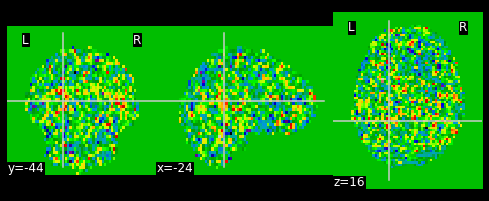

In [15]:
#Set some constants
high_pass= 0.009
low_pass = 0.08
t_r = 2

#Clean!
clean_img = img.clean_img(func_img,confounds=confounds_matrix,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask)

#Let's visualize our result! Doesn't really tell us much, but that's the data we're using for analysis!
plot.plot_epi(clean_img.slicer[:,:,:,50])